<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#데이터셋-구성" data-toc-modified-id="데이터셋-구성-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>데이터셋 구성</a></span><ul class="toc-item"><li><span><a href="#data-normalization" data-toc-modified-id="data-normalization-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>data normalization</a></span></li><li><span><a href="#image-visualization" data-toc-modified-id="image-visualization-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>image visualization</a></span></li><li><span><a href="#setting-batch_size" data-toc-modified-id="setting-batch_size-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>setting batch_size</a></span></li></ul></li><li><span><a href="#생성자-구현하기(가짜이미지-출력하는-함수)" data-toc-modified-id="생성자-구현하기(가짜이미지-출력하는-함수)-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>생성자 구현하기(가짜이미지 출력하는 함수)</a></span><ul class="toc-item"><li><span><a href="#generator-변수생성" data-toc-modified-id="generator-변수생성-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>generator 변수생성</a></span></li></ul></li><li><span><a href="#판별자-구현하기" data-toc-modified-id="판별자-구현하기-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>판별자 구현하기</a></span><ul class="toc-item"><li><span><a href="#판별자-변수생성" data-toc-modified-id="판별자-변수생성-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>판별자 변수생성</a></span></li></ul></li><li><span><a href="#손실함수와-최적화-함수-만들기" data-toc-modified-id="손실함수와-최적화-함수-만들기-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>손실함수와 최적화 함수 만들기</a></span></li><li><span><a href="#모델훈련" data-toc-modified-id="모델훈련-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>모델훈련</a></span><ul class="toc-item"><li><span><a href="#노이즈벡터-생성(16,100)" data-toc-modified-id="노이즈벡터-생성(16,100)-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>노이즈벡터 생성(16,100)</a></span></li></ul></li><li><span><a href="#회고" data-toc-modified-id="회고-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>회고</a></span></li></ul></div>

In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

# 데이터셋 구성

In [2]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

170508288/170498071 [==============================] - 3s 0us/step


(50000, 32, 32, 3)

## data normalization

In [3]:
# 전 
print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [4]:
# 후
train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화
'''When you use ReLU because there is no limit for its output, 
you have to normalize the input data and also use initialization techniques that avoid having large values for weights.
양의기울기로만 편향되는 것을 막기위해

'''

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
train_x.shape

(50000, 32, 32, 3)

딥러닝에서 이미지를 다루려면 채널 수에 대한 차원이 필요, 컬러이미지 확인

In [6]:
train_x.shape[0]

50000

In [7]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

## image visualization

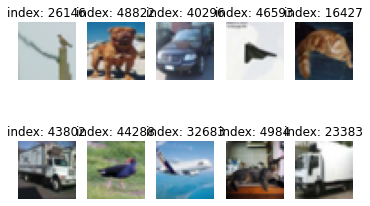

In [8]:
import matplotlib.pyplot as plt
import numpy as np

for i in range(10):
    plt.subplot(2, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index]+1)/2)
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

    오류: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
     :정규화간 픽셀값이 -1 ~ 1 로 정규화되어있으나 imshow 의 RGB data는 0~1 까지 인식.  +1을 해주어 양수로 만들어줌, 양수의 경우 최대 2이므로 1/2 해줌

In [9]:
print(np.min(train_x[ : :]))
print(np.max(train_x[ : :]))

-1.0
1.0


## setting batch_size

In [10]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [11]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [12]:
train_dataset

<BatchDataset shapes: (None, 32, 32, 3), types: tf.float32>

# 생성자 구현하기(가짜이미지 출력하는 함수)

In [13]:
from tensorflow.keras import layers

# Keras Sequential API를 활용
def make_generator_model():

    # Start
    model = tf.keras.Sequential()
    
    dropout= 1.0
    depth = 256+256+256+256
    dim = 4   
    # in: 100
    # out: dim x dim x depth
    
    # First: Dense layer
    #모델은 입력값으로 (batch_size, 100) 형상의 노이즈 벡터를 받음
    #입력된 (batch_size, 100) 벡터는 (1024x2x2)*100 = 4096개의 노드 
    #첫 번째 Dense 레이어를 거치며 (batch_size, 4096) 형상의 벡터.
    
    # Second: Reshape layer
    #첫 번째 레이어를 지난 후 벡터는 Reshape 레이어를 지나게 됩니다.
    #이는 이후의 Layer에서 Convolutional 연산을 할 수 있도록 1차원 벡터를 (2,2,1024) 형상의 3차원 벡터

    model.add(layers.Dense(dim*dim*depth, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((dim, dim, depth)))
#     model.add(layers.Dropout(dropout))  

    # in : dim x dim x depth
    # out : 2*dim x 2*dim x depth/2
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose((int(depth/2)), kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose((int(depth/4)), kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
   
#     # Fifth: Conv2DTranspose layer
#     model.add(layers.Conv2DTranspose((int(depth/8)), kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
    
    # out : 32 x 32 x 3 RGB scale
    # sixth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

## generator 변수생성

In [14]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         13107200  
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 512)         0

In [15]:
noise = tf.random.normal([1, 100]) #정규분포 난수생성

# tf.random.normal(
#     shape,
#     mean=0.0,
#     stddev=1.0,
#     dtype=tf.dtypes.float32,
#     seed=None,
#     name=None
# )

In [16]:
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

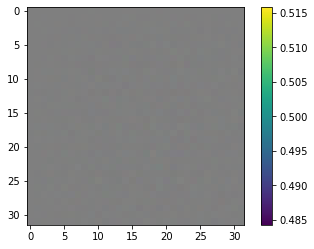

In [17]:
plt.imshow((generated_image[0]+1)/2.0)
plt.colorbar()
plt.show()

# 판별자 구현하기

In [18]:
def make_discriminator_model():
    # Start
    model = tf.keras.Sequential()

    dropout= 0.3
    depth = 256+256+256+256
    # in : 32 x 32 x 3
    # out : 1 
    model.add(layers.Conv2D((int(depth/8)), (5, 5),  strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Conv2D((int(depth/4)), (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))
    
    model.add(layers.Conv2D((int(depth/2)), (4, 4), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(dropout))

    model.add(layers.Flatten())

    model.add(layers.Dense(1))

    return model

## 판별자 변수생성

In [19]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 512)        

In [20]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00070973]], dtype=float32)>

# 손실함수와 최적화 함수 만들기

In [21]:
# 교차 엔트로피(binary cross entropy)를 사용
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)


In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [23]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [24]:
def discriminator_accuracy(real_output, fake_output):
    # (1) tf.math.greater_equal() : real_output의 각 원소가 0.5 이상인지 True, False로 판별
    # (2) tf.cast() : (1)의 결과가 True이면 1.0, False이면 0.0으로 변환
    #(2)의 결과를 평균내어 이번 배치의 정확도(accuracy)를 계산
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32)) 
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [25]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #lr=0.0001
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False) #lr=0.001(default)

# 모델훈련

## 노이즈벡터 생성(16,100)

In [26]:
# 100차원의 노이즈 16개 (16,100) 벡터생성
noise_dim = 100
num_examples_to_generate = 16 #샘플은 한번에 16장 생성

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [27]:
@tf.function
def train_step(images):  #(1) 입력데이터(real image data 입력)
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈
    
    
    #중간 연산 과정(함수, 연산)을 테이프(tape)에 차곡차곡 기록해주는 Gradient tapes 를 사용
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True) #실제이미지 출력
        fake_output = discriminator(generated_images, training=True) #생성이미지 출력

        #(6) loss 계산
        gen_loss = generator_loss(fake_output) 
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [28]:
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i]+1)/2.0)
        plt.axis('off')

    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples2/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [29]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history2/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

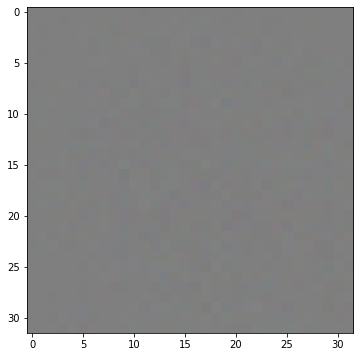

In [30]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints2'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)


latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.


In [31]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [32]:
save_every = 5
EPOCHS = 30
# 사용가능한 GPU 디바이스 확인
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

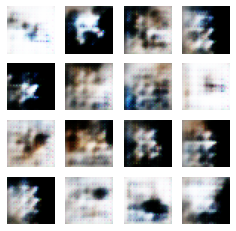

Time for training : 3334 sec


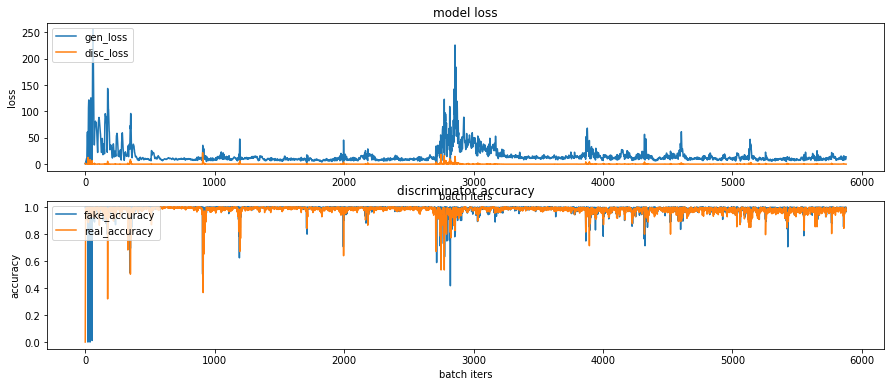

CPU times: user 59min 51s, sys: 2min 24s, total: 1h 2min 16s
Wall time: 55min 35s


In [33]:
%%time
train(train_dataset, EPOCHS, save_every)

In [34]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline

anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples1/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

-rw-r--r-- 1 root root 1097872 Dec 18 03:46 /aiffel/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif


# 회고

    1. Case1
    Generator learning rate = 0.001 / Discriminator learning rate = 0.001 / epoch =50

        문제점
        1.1 <Mode Collapse> (비슷한 이미지만 계속 생성하는 경우) 발생 
        1.2 일정주기마다 (20 epoch 정도) 생성자의 loss값이 급격히 상승하는 경향이 있으나, 비이상적인 생성자의 손실값도 이내 안정을 찾아가기 때문에 정
        상적이라고 보는 견해도 있었음.
        1.3 이미지의 특성을 알아챌 수 있을 만한 단서를 찾지 못했으며, 학습이 진행되는 동안 이미지의 발전(sharpness)를 찾지 못했다. 
        1.4 시간에 지남에도 학습률이 저조한 것으로 보여 case2에서 epoch를 50 -> 30으로 줄여봄

    2. Case2 
    Generator learning rate = 0.0001 / Discriminator learning rate = 0.001 / epoch =30
  
  
        2.1 아래의 참에 따라 생성자는 꼼꼼하게, 판별자는 널널하게 학습을 시키기 위해 학습률을 조정하여 진행해 보았으며, 
        이미지의 디테일이 전보다 향상되었으나 큰 효과는 느끼지 못하였음. 
        ref) https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628
        14: [notsure] Train discriminator more (sometimes)
        especially when you have noise
        hard to find a schedule of number of D iterations vs G iterations
        
        2.2 generator의 input image
        generator의 input image(4x4)를 kennel image(5x5)보다 작게 시작할 경우 padding처리되는지 궁금함.. padding 처리가 되었다면 transposed 
        convolution과정에서 padding된 정보들이 확대되었을 것으로 보이며, 이 경우는 원본 이미지의 정확도면에서 부정적인 면이 있지 않을까?? 

    3. accuracy의 경우 0.8~1사이에서 fluctuating하고 있으나 후반부로 갈수록 더 높은 강도로 flucuating하고 있음.



Case1의 gif 파일

![gif](cifar10_dcgan_default.gif)

Case2의 gif 파일

![gif](cifar10_dcgan_optimized.gif)